<a href="https://colab.research.google.com/github/saad415/Deep-learning/blob/main/text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])
df.head(10)

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,87,24.0,Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,87,12.0,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,87,27.0,Pinot Gris,Jean-Baptiste Adam


In [5]:
df = df.dropna(subset=["description", "points"])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


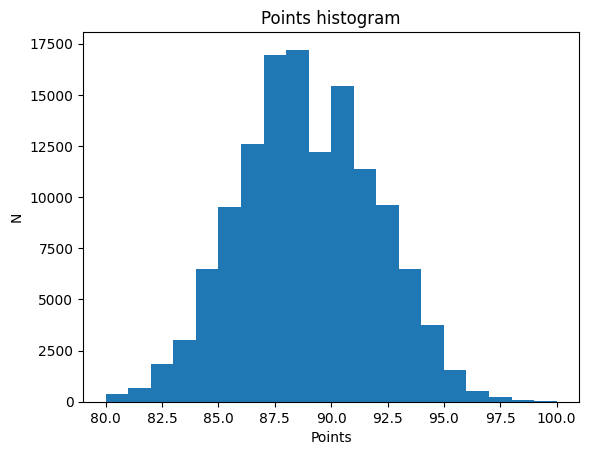

In [6]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [7]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [13]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)


In [14]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [15]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.32643008,  0.02374815,  0.28309292, ...,  0.17282173,
        -0.17165141,  0.1759984 ],
       [ 0.3166777 , -0.0603782 , -0.15088017, ..., -0.1266913 ,
        -0.2138411 ,  0.06751934],
       [ 0.3417148 , -0.13238868, -0.0465618 , ...,  0.42082062,
        -0.03393935, -0.15154694],
       ...,
       [ 0.49972576,  0.1388202 ,  0.15121141, ...,  0.25659156,
        -0.0828481 ,  0.17118028],
       [ 0.57063305,  0.11599115,  0.2319919 , ...,  0.16714486,
        -0.42058188, -0.09574571],
       [ 0.38662845, -0.31896043, -0.13113058, ...,  0.01531304,
        -0.24899061, -0.13663775]], dtype=float32)>

In [16]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4880147 , -0.08113587,  0.14380285, ...,  0.07135354,
        -0.02381008,  0.19139273],
       [ 0.27282304, -0.43391404, -0.08807148, ...,  0.2207743 ,
         0.082323  ,  0.03822576],
       [ 0.39846644, -0.39287716, -0.10508378, ..., -0.00841983,
        -0.11306078, -0.13868591],
       ...,
       [ 0.42996255, -0.24965549,  0.03899297, ...,  0.04227261,
        -0.23011374,  0.1773411 ],
       [ 0.50074375, -0.20196882,  0.1282116 , ...,  0.23899679,
         0.03265096,  0.1510696 ],
       [ 0.39637923,  0.01034996,  0.1491205 , ..., -0.15594208,
        -0.03438752,  0.25068387]], dtype=float32)>

In [17]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.evaluate(train_data)

102/102 [==============================] - 5s 15ms/step - loss: 0.6977 - accuracy: 0.4295


[0.6977318525314331, 0.4294741153717041]

In [20]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 26ms/step - loss: 0.6982 - accuracy: 0.4229


[0.6981652975082397, 0.4228668212890625]

In [21]:
history = model.fit(train_data, epochs=3, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 145s 1s/step - loss: 0.6430 - accuracy: 0.6282 - val_loss: 0.5274 - val_accuracy: 0.7858
Epoch 2/5
102/102 [==============================] - 129s 1s/step - loss: 0.4883 - accuracy: 0.7732 - val_loss: 0.3980 - val_accuracy: 0.8198
Epoch 3/5
102/102 [==============================] - 127s 1s/step - loss: 0.4060 - accuracy: 0.8247 - val_loss: 0.3772 - val_accuracy: 0.8267
Epoch 4/5
102/102 [==============================] - 131s 1s/step - loss: 0.3662 - accuracy: 0.8457 - val_loss: 0.3738 - val_accuracy: 0.8295
Epoch 5/5
102/102 [==============================] - 144s 1s/step - loss: 0.3424 - accuracy: 0.8578 - val_loss: 0.3741 - val_accuracy: 0.8294


**LSTM**

In [22]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [23]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [26]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 157ms/step - loss: 0.6917 - accuracy: 0.6252


[0.6917142868041992, 0.6252211928367615]

In [28]:
history = model.fit(train_data, epochs=3, validation_data=valid_data)

Epoch 1/3
102/102 [==============================] - 57s 560ms/step - loss: 0.4808 - accuracy: 0.7591 - val_loss: 0.3717 - val_accuracy: 0.8278
Epoch 2/3
102/102 [==============================] - 56s 547ms/step - loss: 0.3628 - accuracy: 0.8378 - val_loss: 0.3517 - val_accuracy: 0.8433
Epoch 3/3
102/102 [==============================] - 55s 538ms/step - loss: 0.3475 - accuracy: 0.8456 - val_loss: 0.3503 - val_accuracy: 0.8407
